_**Sinh viên thực hiện:**_



Bùi Thanh Dân - 23020342: Part 1

Phạm Tiến Dũng - 23020345: Part 2

Vũ Nguyên Đan - 23020351: Part 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Giới thiệu doanh nghiệp**

Công ty Cổ phần Sữa Việt Nam (Vinamilk - mã cổ phiếu: VNM) là doanh nghiệp đầu ngành và chiếm thị phần lớn nhất trong lĩnh vực sản xuất, chế biến các sản phẩm từ sữa tại Việt Nam.

##### **Vị thế và quy mô:**

* Vinamilk sở hữu hệ thống trang trại hiện đại và mạng lưới phân phối rộng khắp cả nước, cùng với việc mở rộng hoạt động xuất khẩu sang nhiều thị trường quốc tế.

* Kể từ khi niêm yết trên Sở Giao dịch Chứng khoán Thành phố Hồ Chí Minh (HOSE) vào năm 2006, VNM luôn được xem là một trong những cổ phiếu blue-chip trụ cột với vốn hóa thị trường lớn nhất, có ảnh hưởng quan trọng đến chỉ số VN-Index.

##### **Các yếu tố tác động đến hoạt động/giá trị cổ phiếu:**

* **Giá nguyên liệu Đầu vào:** Sự biến động của giá sữa bột và thức ăn chăn nuôi trên thị trường toàn cầu.

* **Sức mua:** Sự thay đổi của nhu cầu tiêu dùng nội địa và triển vọng xuất khẩu.

* **Biến động vĩ mô:** Các yếu tố kinh tế vĩ mô, chính sách tiền tệ và sự thay đổi của tỷ giá ngoại tệ (do công ty có nhập khẩu nguyên liệu).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import unicodedata
from typing import List, Optional
import re
import seaborn as sns

#### **1. Quan sát để hiểu doanh nghiệp và dữ liệu**

##### **1.1. Dữ liệu**

Sử dụng hai bảng dữ liệu được cung cấp:

- **Simplize_VNM_PriceHistory_20250315.xlsx:** Lịch sử giá cổ phiếu theo ngày.
- **Simplize_VNM_FinancialIndicator_20250315.xlsx:** Chỉ số tài chính theo quý.

Dữ liệu bao phủ giai đoạn **2021–2025**, gồm khoảng **1.000 dòng dữ liệu** cho lịch sử giá và 4**0 quý** cho các chỉ số tài chính.

In [ ]:
FINANCIAL_REPORT_PATH = Path("/content/drive/MyDrive/Datamining/Simplize_VNM_FinancialIndicator_20250315.xlsx")
PRICE_HISTORY_PATH  = Path("/content/drive/MyDrive/Datamining/Simplize_VNM_PriceHistory_20250315.xlsx")

pd.options.display.float_format = "{:,.4f}".format
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

##### **1.2. Đọc dữ liệu và tiền xử lý đơn giản**

Tiền xử lý dữ liệu đơn giản bằng 3 hàm sau:

- `normalize_text`: Hàm này làm sạch một chuỗi text bằng cách: loại bỏ dấu (diacritics), chuyển thành chữ thường, và xóa các khoảng trắng hoặc ký tự xuống dòng thừa.
- `to_number`: Hàm này cố gắng biến một chuỗi (ví dụ "1,000.50" hoặc "50%") thành một số float. Nó xử lý linh hoạt các dấu phẩy, chấm, ký hiệu phần trăm (%), và trả về `NaN` (Not a Number) nếu không thể chuyển đổi.
- `infer_header_row`: Hàm này duyệt qua DataFrame để tìm xem hàng nào chứa các tên cột mong đợi (expected_keys). Nó trả về chỉ số (index) của hàng đó.

In [ ]:
def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return s
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower().strip()
    s = s.replace("\n", " ").replace("\r", " ")
    while "  " in s:
        s = s.replace("  ", " ")
    return s

def to_number(x):
    if isinstance(x, (int, float, np.number)):
        return float(x)
    if not isinstance(x, str):
        return np.nan
    s = x.strip().replace(" ", "")
    if s == "":
        return np.nan
    allowed = set("0123456789-.,%")
    s = "".join(ch for ch in s if ch in allowed)
    pct = s.endswith("%")
    if pct:
        s = s[:-1]

    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(".", "").replace(",", ".")
    elif s.count(".") > 1:
        s = s.replace(".", "")
    try:
        val = float(s)
        return val/100 if pct else val
    except:
        return np.nan

def infer_header_row(df_raw: pd.DataFrame, expected_keys: List[str]) -> int:
    keys_norm = [normalize_text(k) for k in expected_keys]
    for i, row in df_raw.iterrows():
        row_texts = [normalize_text(str(x)) for x in row.tolist()]
        if any(any(k in cell for k in keys_norm) for cell in row_texts):
            return i
    return 0

Đọc dữ liệu báo cáo tài chính:

In [ ]:
financial_raw = pd.read_excel(FINANCIAL_REPORT_PATH, sheet_name=0, header=None)

header_row = infer_header_row(financial_raw, ["chi tieu", "q1", "q2", "q3", "q4"])
financial = financial_raw.iloc[header_row + 1:].copy()
financial.columns = financial_raw.iloc[header_row].tolist()
financial = financial.reset_index(drop=True)

financial.columns = [normalize_text(str(c)).strip() for c in financial.columns]
for col in financial.columns:
    numeric_ratio = financial[col].apply(
        lambda x: isinstance(x, (int, float, np.number)) or
                  (isinstance(x, str) and any(ch.isdigit() for ch in x))
    ).mean()
    if numeric_ratio > 0.5:
        financial[col] = financial[col].apply(to_number)
financial = financial.dropna(how="all").reset_index(drop=True)

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
financial.head(5)

,chi tieu,q4/2024,q3/2024,q2/2024,q1/2024,q4/2023,q3/2023,q2/2023,q1/2023,q4/2022,q3/2022,q2/2022,q1/2022,q4/2021,q3/2021,q2/2021,q1/2021,q4/2020,q3/2020,q2/2020,q1/2020,q4/2019,q3/2019,q2/2019,q1/2019,q4/2018,q3/2018,q2/2018,q1/2018,q4/2017,q3/2017,q2/2017,q1/2017,q4/2016,q3/2016,q2/2016,q1/2016,q4/2015,q3/2015,q2/2015,q1/2015
0,Chỉ tiêu Báo cáo kết quả kinh doanh (Tỷ đồng),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Doanh thu thuần,"15,477,073,125,441.0000","15,537,337,313,473.0000","16,655,787,772,473.0000","14,112,411,317,058.0000","15,618,710,944,490.0000","15,636,987,684,682.0000","15,194,824,955,693.0000","13,918,391,926,640.0000","15,068,654,657,453.0000","16,079,491,424,130.0000","14,930,275,292,637.0000","13,877,825,823,198.0000","15,819,036,553,270.0000","16,194,052,003,559.0000","15,715,806,166,465.0000","13,190,270,122,852.0000","14,424,794,514,944.0000","15,563,157,998,229.0000","15,495,233,758,799.0000","14,153,099,953,575.0000","14,238,961,478,162.0000","14,290,900,447,018.0000","14,598,960,549,757.0000","13,189,300,287,807.0000","13,003,707,052,570.0000","13,735,260,285,149.0000","13,702,480,611,961.0000","12,120,502,020,912.0000","12,350,368,157,140.0000","13,293,077,820,340.0000","13,348,261,215,191.0000","12,049,368,692,438.0000","11,807,610,749,506.0000","12,204,689,711,230.0000","12,449,130,059,922.0000","10,332,908,879,616.0000","11,098,562,112,893.0000","10,549,326,431,578.0000","10,500,110,637,280.0000","8,716,035,913,568.0000"
2,Tăng trưởng doanh thu,-0.0091,-0.0064,0.0961,0.0139,0.0365,-0.0275,0.0177,0.0029,-0.0474,-0.0071,-0.0500,0.0521,0.0967,0.0405,0.0142,-0.0680,0.0131,0.0890,0.0614,0.0731,0.0950,0.0405,0.0654,0.0882,0.0529,0.0333,0.0265,0.0059,0.0460,0.0892,0.0722,0.1661,0.0639,0.1569,0.1856,0.1855,0.1889,0.2082,0.1373,0.1352
3,Lợi nhuận gộp,"6,209,690,644,985.0000","6,401,445,454,290.0000","7,067,518,779,284.0000","5,911,521,444,565.0000","6,441,612,591,490.0000","6,554,900,643,375.0000","6,150,192,068,886.0000","5,398,026,311,659.0000","5,845,588,412,045.0000","6,350,179,642,297.0000","6,076,659,801,599.0000","5,624,803,650,766.0000","6,725,316,780,217.0000","6,943,747,090,431.0000","6,854,357,185,245.0000","5,754,880,436,414.0000","6,658,173,701,548.0000","7,266,743,481,136.0000","7,137,894,597,099.0000","6,605,811,607,925.0000","6,680,302,621,448.0000","6,722,965,970,468.0000","7,013,945,549,158.0000","6,155,002,509,553.0000","6,162,585,412,139.0000","6,493,516,898,029.0000","6,468,610,841,811.0000","5,486,693,317,112.0000","5,603,872,290,875.0000","6,270,299,324,342.0000","6,540,841,887,346.0000","5,819,131,316,070.0000","5,480,295,049,931.0000","5,085,428,772,710.0000","5,372,695,831,441.0000","5,026,711,161,429.0000","4,416,387,446,733.0000","4,350,059,534,037.0000","4,386,995,984,476.0000","3,108,971,976,990.0000"
4,Tăng trưởng lợi nhuận gộp,-0.0360,-0.0234,0.1492,0.0951,0.1020,0.0322,0.0121,-0.0403,-0.1308,-0.0855,-0.1135,-0.0226,0.0101,-0.0444,-0.0397,-0.1288,-0.0033,0.0809,0.0177,0.0732,0.0840,0.0353,0.0843,0.1218,0.0997,0.0356,-0.0110,-0.0571,0.0225,0.2330,0.2174,0.1576,0.2409,0.1690,0.2247,0.6168,0.2440,0.4363,0.3860,0.2123


Đọc dữ liệu lịch sử giá:

In [ ]:
price_raw = pd.read_excel(PRICE_HISTORY_PATH, sheet_name=0, header=None)

header_row_price = infer_header_row(price_raw, ["gia mo cua", "gia cao nhat", "gia thap nhat", "gia dong cua", "thay doi gia"])
price = price_raw.iloc[header_row_price + 1:].copy()
price.columns = price_raw.iloc[header_row_price].tolist()
price = price.reset_index(drop=True)

price.columns = [normalize_text(str(c)).strip() for c in price.columns]
price['ngay'] = pd.to_datetime(price['ngay'], dayfirst=True, errors="coerce")
for col in price.columns:
    if col != "ngay":
        price[col] = price[col].apply(to_number)

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
price.head(5)

,ngay,gia mo cua,gia cao nhat,gia thap nhat,gia đong cua,thay đoi gia,% thay đoi,khoi luong
0,2025-03-14,"62,400.0000","62,700.0000","62,100.0000","62,100.0000",100.0000,0.0016,"2,696,700.0000"
1,2025-03-13,"62,300.0000","62,900.0000","61,900.0000","62,000.0000",-200.0000,-0.0032,"5,100,400.0000"
2,2025-03-12,"62,500.0000","62,800.0000","62,200.0000","62,200.0000",-200.0000,-0.0032,"2,755,400.0000"
3,2025-03-11,"62,300.0000","62,500.0000","62,100.0000","62,400.0000",-100.0000,-0.0016,"2,287,600.0000"
4,2025-03-10,"63,000.0000","63,000.0000","62,500.0000","62,500.0000",-200.0000,-0.0032,"2,529,500.0000"


##### **1.3. Thống kê miêu tả**

Sử dụng hàm `descriptive_summary` để tính toán các chỉ số quan trọng:

In [ ]:
def descriptive_summary(df: pd.DataFrame) -> pd.DataFrame:
    num = df.select_dtypes(include=[np.number])
    return pd.DataFrame({
        "count": num.count(),
        "min":   num.min(),
        "Q1":    num.quantile(0.25),
        "median(Q2)": num.median(),
        "Q3":    num.quantile(0.75),
        "max":   num.max(),
        "mean":  num.mean(),
        "std":   num.std(ddof=1),
        "var":   num.var(ddof=1),
    })

Dữ liệu thống kê:

In [ ]:
price_stats = descriptive_summary(price.select_dtypes(include=[np.number]))
print("Descriptive statistics - Price history:")
display(price_stats)

Descriptive statistics - Price history:


,count,min,Q1,median(Q2),Q3,max,mean,std,var
gia mo cua,1000,"56,214.8111","64,018.1539","67,571.0007","72,110.8986","86,174.4921","68,190.5618","5,260.2948","27,670,701.2087"
gia cao nhat,1000,"57,423.7318","64,495.3416","68,099.1461","72,710.8525","86,174.4921","68,783.3562","5,284.9268","27,930,451.2683"
gia thap nhat,1000,"55,696.7022","63,611.6482","67,037.3783","71,477.9757","84,277.8287","67,603.1443","5,192.6055","26,963,152.2538"
gia đong cua,1000,"55,696.7022","63,992.7177","67,571.0007","72,051.6628","84,690.1468","68,111.6652","5,246.7476","27,528,360.6573"
thay đoi gia,547,"-2,500.0000",-500.0000,-100.0000,400.0000,"3,900.0000",-14.9909,811.2951,"658,199.7710"
% thay đoi,547,-0.0338,-0.0065,-0.0013,0.0055,0.0576,-0.0002,0.0115,0.0001
khoi luong,1000,"691,300.0000","1,932,900.0000","2,702,950.0000","3,882,825.0000","21,564,900.0000","3,131,697.2230","1,819,471.4280","3,310,476,277,282.1602"


In [ ]:
financial_stats = descriptive_summary(financial)
print("Descriptive statistics - Financial report:")
display(financial_stats)

Descriptive statistics - Financial report:


,count,min,Q1,median(Q2),Q3,max,mean,std,var
q4/2024,52,-0.4482,0.1012,1.6196,"842,246,219,439.0000","132,085,184,124,000.0000","6,851,637,486,550.5957","20,872,059,003,481.7695","435,642,847,044,824,375,918,329,856.0000"
q3/2024,53,-0.5717,0.1547,1.6267,"411,532,810,496.0000","134,384,135,113,500.0000","6,921,950,357,570.4795","21,178,698,531,429.4219","448,537,271,485,170,672,931,438,592.0000"
q2/2024,53,-0.4239,0.2081,2.0001,"453,196,649,401.0000","152,357,751,940,500.0000","7,106,863,604,591.4424","23,085,243,555,132.9531","532,928,469,999,807,590,136,020,992.0000"
q1/2024,53,-0.4246,0.1820,1.8460,"491,891,149,713.0000","137,937,059,370,000.0000","6,567,115,508,241.1641","21,107,200,009,177.8594","445,513,892,227,437,763,063,971,840.0000"
q4/2023,53,-0.4166,0.2414,1.7392,"508,937,364,128.0000","140,027,014,815,000.0000","6,738,316,118,039.2002","21,429,065,733,087.9922","459,204,858,193,006,088,899,526,656.0000"
q3/2023,53,-0.5509,0.1620,1.5678,"565,044,030,094.0000","141,071,992,537,500.0000","6,879,171,320,592.9600","21,707,244,970,421.1133","471,204,484,205,872,724,293,189,632.0000"
q2/2023,53,-0.3889,0.1467,1.9707,"565,949,667,885.0000","157,791,636,097,500.0000","6,920,308,323,206.8564","23,484,171,356,430.5703","551,506,304,298,193,985,871,020,032.0000"
q1/2023,53,-0.3704,0.0029,1.7831,"346,676,448,782.0000","153,611,725,207,500.0000","6,698,056,326,716.3281","22,828,684,939,812.4336","521,148,856,081,219,098,249,265,152.0000"
q4/2022,53,-0.4812,-0.0174,1.6999,"357,722,799,611.0000","155,492,685,108,000.0000","6,679,568,147,450.0400","22,993,782,378,417.2812","528,714,028,066,013,023,341,379,584.0000"
q3/2022,53,-0.3819,0.0406,1.6838,"372,252,790,415.0000","160,926,569,265,000.0000","7,081,329,429,035.2197","23,860,856,328,748.7617","569,340,464,741,189,765,121,966,080.0000"


##### **1.4. Theo dõi sự biến động của giá cổ phiếu**

Xác định và gán giá đóng cửa (closing price) cuối cùng của cổ phiếu VNM vào ngày hoặc ngay trước ngày kết thúc của mỗi quý (từ $31/03/2021$ đến $31/12/2025$) bằng cách sử dụng phép nối dữ liệu thời gian (`pd.merge_asof`).

In [ ]:
quarter_ends = pd.date_range("2021-03-31", "2025-12-31", freq="Q")

tmp_price = price.dropna(subset=['ngay', 'gia đong cua']).copy()

tmp_price['ngay'] = pd.to_datetime(tmp_price['ngay'], errors='coerce')
tmp_price = tmp_price.dropna(subset=['ngay']).sort_values('ngay')

map_q = pd.DataFrame({"quarter_end": pd.to_datetime(quarter_ends)}).sort_values("quarter_end")

map_q = pd.merge_asof(
    left=map_q.sort_values("quarter_end"),
    right=tmp_price.rename(columns={'ngay': 'date'}),
    left_on="quarter_end",
    right_on="date",
    direction="backward"
)

/tmp/ipython-input-1624660929.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_ends = pd.date_range("2021-03-31", "2025-12-31", freq="Q")


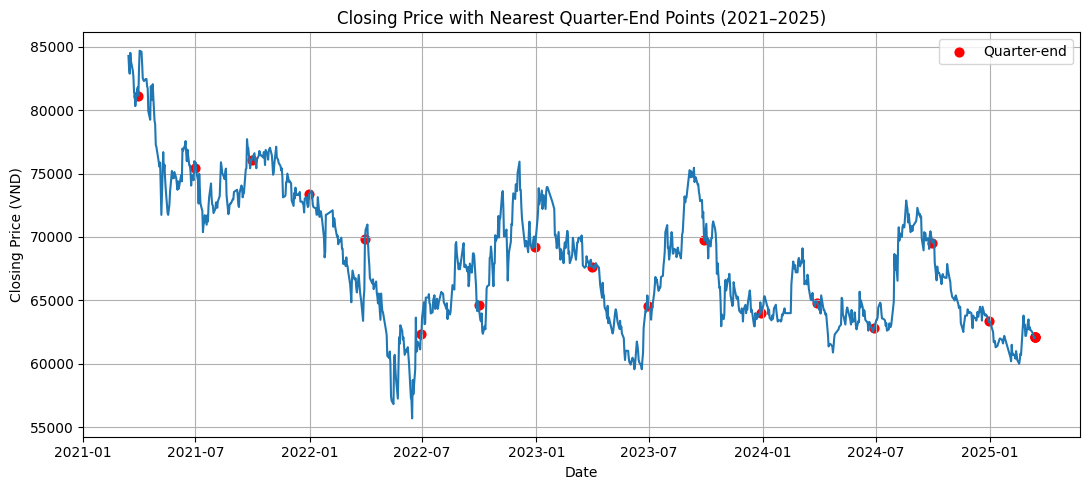

In [ ]:
plt.figure(figsize=(11, 5))
plt.plot(price['ngay'], price['gia đong cua'], linewidth=1.5)

sel = map_q.dropna(subset=["date"])
plt.scatter(sel["date"], sel["gia đong cua"], s=40, color='red', marker="o", label="Quarter-end")
plt.title("Closing Price with Nearest Quarter-End Points (2021–2025)")
plt.xlabel("Date")
plt.ylabel("Closing Price (VND)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Biểu đồ trên cho thấy giá cổ phiếu VNM trải qua hai giai đoạn biến động chính:

**Giai đoạn 1**: Xu Hướng Giảm Rõ Rệt (Downtrend)
* Thời gian: Đầu năm $2021$ đến Giữa năm $2022$.
* Diễn biến: Giá cổ phiếu bắt đầu ở mức đỉnh cao (khoảng $\text{84,000} - \text{85,000 VND}$) vào Quý 1/$2021$. Sau đó, giá bước vào một giai đoạn giảm sâu và kéo dài, tuân theo quy tắc của một xu hướng giảm rõ rệt (các đỉnh và đáy sau thấp hơn các đỉnh và đáy trước).
* Điểm kết thúc: Xu hướng giảm kết thúc khi giá chạm mức đáy (khoảng $\text{56,000} - \text{58,000 VND}$) vào khoảng giữa năm $2022$.
* Nguyên nhân cơ bản: Xu hướng giảm này phản ánh sự suy giảm của kết quả kinh doanh do áp lực kép từ chi phí nguyên liệu đầu vào tăng cao và sự cạnh tranh khốc liệt trong thị trường sữa nội địa.

**Giai đoạn 2**: Biến Động Đi Ngang (Sideways Volatility)
* Thời gian: Giữa năm $2022$ đến Đầu năm $2025$.
* Diễn biến: Sau khi tạo đáy, giá cổ phiếu ngừng giảm sâu và chuyển sang trạng thái dao động tích lũy trong một biên độ rộng (chủ yếu từ $\text{60,000 VND}$ đến $\text{75,000 VND}$). Thị trường liên tục ghi nhận các đợt tăng và giảm ngắn hạn, thể hiện sự giằng co giữa lực mua và lực bán mà không có bên nào đủ sức thiết lập một xu hướng tăng trưởng bền vững hoặc một đợt giảm mới.
* Lý do ổn định hơn:
  * Sự ổn định này được hỗ trợ bởi những nỗ lực nội tại của doanh nghiệp, bao gồm:Cải thiện biên lợi nhuận nhờ tối ưu hóa chi phí.
  * Tái cấu trúc hệ thống phân phối và danh mục sản phẩm.
  * Tăng trưởng doanh thu từ thị trường xuất khẩu.
  * Kỳ vọng tích cực từ sự phục hồi của GDP và nhu cầu tiêu dùng chung sau đại dịch.

#### **2. Tiền xử lý dữ liệu**

Mục tiêu của phần này là tạo ra một bảng dữ liệu mới, duy nhất từ hai nguồn dữ liệu đã cho (`Simplize_VNM_PriceHistory` và `Simplize_VNM_FinancialIndicator`). Bảng dữ liệu mới này sẽ có tần suất theo quý và chứa các chỉ số tài chính cùng với giá cổ phiếu đã được xử lý tương ứng, sẵn sàng cho việc phân tích và xây dựng mô hình ở các bước tiếp theo.

Quá trình này bao gồm các bước chính sau:

##### **2.1. Tạo bảng dữ liệu mới từ hai bảng đã cho**

###### **2.1.1 Chuyển đổi định dạng dữ liệu tài chính**

Dữ liệu tài chính ban đầu có các chỉ số ở dạng hàng và các quý ở dạng cột. Để có thể kết hợp với dữ liệu giá theo chuỗi thời gian, chúng ta cần chuyển đổi bảng dữ liệu này sao cho mỗi hàng đại diện cho một quý duy nhất và mỗi cột là một chỉ số tài chính.

In [ ]:
financial_long = financial.set_index('chi tieu')
financial_long = financial_long.transpose()
financial_long = financial_long.reset_index()
financial_long = financial_long.rename(columns={'index': 'quarter_str'})

###### **2.1.2. Chuẩn hóa và chuyển đổi cột thời gian**

Cột thời gian (`quarter_str`) đang ở định dạng chuỗi ký tự (ví dụ: 'q4/2024'). Chúng ta cần chuyển đổi nó sang định dạng `datetime` chuẩn để có thể thực hiện các phép toán thời gian. Hàm `parse_quarter` được tạo để phân tích chuỗi này và trả về ngày cuối cùng của quý tương ứng.

In [ ]:
def parse_quarter(q_str):
    try:
        quarter, year = q_str.split('/')
        quarter_num = int(quarter[1])
        month = quarter_num * 3
        day = pd.Timestamp(year=int(year), month=month, day=1).days_in_month
        return pd.to_datetime(f'{year}-{month}-{day}')
    except:
        return None

financial_long['quarter'] = financial_long['quarter_str'].apply(parse_quarter)
financial_long = financial_long.dropna(subset=['quarter']).reset_index(drop=True)

###### **2.1.3. Tổng hợp dữ liệu giá cổ phiếu theo quý**

Theo yêu cầu của đề bài, giá cổ phiếu của một quý không phải là giá của một ngày duy nhất mà là giá trị trung bình của giá đóng cửa trong một cửa sổ thời gian **±14 ngày** xung quanh ngày kết thúc quý (tức là một khoảng 29 ngày). Điều này giúp làm mượt dữ liệu giá và giảm thiểu các biến động bất thường trong ngắn hạn.

Chúng ta lặp qua mỗi ngày cuối quý, xác định cửa sổ thời gian tương ứng, lọc ra các phiên giao dịch trong khoảng đó và tính giá đóng cửa trung bình.

In [ ]:
price = price.sort_values('ngay').reset_index(drop=True)
quarter_end_dates = financial_long['quarter'].unique()
quarterly_prices = []

for q_date in quarter_end_dates:
    start_date = q_date - pd.Timedelta(days=14)
    end_date = q_date + pd.Timedelta(days=14)
    mask = (price['ngay'] >= start_date) & (price['ngay'] <= end_date)
    price_window = price.loc[mask]

    if not price_window.empty:
        avg_price = price_window['gia đong cua'].mean()
    else:
        avg_price = np.nan

    quarterly_prices.append({
        'quarter': q_date,
        'gia dong cua': avg_price
    })

price_quarterly = pd.DataFrame(quarterly_prices)

###### **2.1.4. Kết hợp dữ liệu tài chính và dữ liệu giá**

Sau khi có hai bảng dữ liệu theo cùng một tần suất quý, chúng ta sử dụng hàm `pd.merge `để kết hợp chúng thành một DataFrame duy nhất (`final_df`). Phép hợp nhất này được thực hiện dựa trên cột `quarter` chung, đảm bảo mỗi dòng trong bảng cuối cùng chứa cả thông tin tài chính và giá cổ phiếu của cùng một quý.

In [ ]:
final_df = pd.merge(financial_long, price_quarterly, on='quarter', how='inner')

###### **2.1.5. Tính toán lại các chỉ số biến động giá**

Vì giá cổ phiếu đã được tổng hợp lại theo quý, các cột `thay doi gia` và `% thay doi` ban đầu không còn chính xác. Chúng ta cần tính toán lại các giá trị này dựa trên giá đóng cửa trung bình của quý mới.

In [ ]:
final_df = final_df.sort_values('quarter', ascending=True).reset_index(drop=True)
final_df['thay doi gia'] = final_df['gia dong cua'].diff()
final_df['% thay doi'] = final_df['gia dong cua'].pct_change()

first_cols = ['quarter', 'gia dong cua', 'thay doi gia', '% thay doi']
other_cols = [col for col in final_df.columns if col not in first_cols and col != 'quarter_str']
final_df = final_df[first_cols + other_cols]

final_df = final_df.sort_values('quarter', ascending=False).reset_index(drop=True)

##### **2.2. Làm sạch và chuẩn hóa dữ liệu**

###### **2.2.1. Chuẩn hóa tên cột**

Tên các cột chỉ số tài chính chứa dấu tiếng Việt và các ký tự đặc biệt. Để thuận tiện cho việc truy cập và xử lý sau này, chúng ta chuẩn hóa tất cả tên cột về dạng chữ thường không dấu, không có ký tự đặc biệt bằng hàm `clean_col_name`.

In [ ]:
# Chuẩn hóa tên cột
def clean_col_name(col_name):
    s = unicodedata.normalize('NFKD', col_name).encode('ascii', 'ignore').decode('utf-8')
    s = s.lower()
    s = re.sub(r'[^a-z0-9]+', ' ', s)
    s = s.strip(' ')
    return s

final_df.columns = [clean_col_name(col) for col in final_df.columns]

###### **2.2.2. Xử lý các giá trị bị thiếu**

Một số chỉ số tài chính có thể không được báo cáo trong một vài quý, dẫn đến dữ liệu bị thiếu. Các cột có tỷ lệ thiếu quá cao (ở đây là 90%) sẽ không mang lại nhiều giá trị cho phân tích và có thể gây lỗi. Vì vậy, chúng ta sẽ xác định và loại bỏ những cột này.

In [ ]:
mode = "threshold"  # choose from "all", "any", or "threshold"
threshold = 0.90    # 90% missing = drop

final_df = final_df.replace(r"^\s*$", np.nan, regex=True)

missing_frac = final_df.isna().mean()

if mode == "all":
    cols_to_drop = missing_frac[missing_frac == 1.0].index.tolist()
elif mode == "any":
    cols_to_drop = missing_frac[missing_frac > 0.0].index.tolist()
elif mode == "threshold":
    cols_to_drop = missing_frac[missing_frac >= threshold].index.tolist()
else:
    raise ValueError("mode must be one of: 'all', 'threshold', 'any'")

if cols_to_drop:
    final_df = final_df.drop(columns=cols_to_drop, errors="ignore")
else:
    print("No columns dropped — all columns have sufficient data.")

###### **2.2.3. Chuyển đổi kiểu dữ liệu sang dạng số**

Dữ liệu tài chính thường chứa các ký tự định dạng như dấu phẩy (,) để ngăn cách hàng nghìn hoặc ký tự phần trăm (%). Các ký tự này khiến cột dữ liệu được đọc vào dưới dạng chuỗi (object) thay vì dạng số, làm cho việc tính toán không thể thực hiện được. Chúng ta xây dựng một hàm để "ép" các cột này về đúng định dạng số (float), xử lý cả dấu phẩy và ký tự phần trăm.

In [ ]:
def force_numeric_fixed(df):
    df2 = df.copy()
    for col in df2.columns:
        if col in ['quarter', 'quarter_str']:
            continue

        s = df2[col].astype(str)

        s = s.str.replace(",", "", regex=False)
        s = s.str.replace(" ", "", regex=False)

        is_percent = s.str.endswith("%")
        s = s.str.replace("%", "", regex=False)

        s = pd.to_numeric(s, errors="coerce")

        s[is_percent] = s[is_percent] / 100.0

        df2[col] = s

    return df2

final_df = force_numeric_fixed(final_df)

##### **2.3. Kết quả cuối cùng**

Sau khi thực hiện tất cả các bước trên, chúng ta thu được một DataFrame `final_df` hoàn chỉnh, sạch sẽ và có cấu trúc. Dữ liệu này đã sẵn sàng cho các bước phân tích thống kê, trực quan hóa và xây dựng mô hình ở phần 3.

In [ ]:
final_df.head(5)

,quarter,gia dong cua,thay doi gia,thay doi,doanh thu thuan,tang truong doanh thu,loi nhuan gop,tang truong loi nhuan gop,loi nhuan thuan tu hkd,tang truong loi nhuan thuan,loi nhuan truoc thue,tang truong loi nhuan truoc thue,loi nhuan sau thue cua co ong cong ty me,tang truong loi nhuan sau thue,tong tai san,tang truong tong tai san,tai san ngan han,tang truong tai san ngan han,tai san dai han,tang truong tai san dai han,no ngan han,tang truong no ngan han,vay va no thue tai chinh ngan han,tang truong vay va no thue tai chinh ngan han,no dai han,tang truong no dai han,von chu so huu,tang truong von chu so huu,von gop co phan,tang truong von gop co phan,p e,p b,ev ebitda,eps vn cp,tang truong eps,gia tri so sach vn cp,bien loi nhuan gop,bien ebit,bien ebitda,bien loi nhuan rong,roe ltm,roa ltm,vong quay tai san vong,hieu suat su dung tai san co inh,so ngay thu tien khach hang ngay,so ngay xu ly hang ton kho ngay,so ngay phai tra nha cung cap ngay,vong quay tien mat ngay,no phai tra von chu so huu,vay va no thue tai chinh ngan han dai han von chu so huu,no vay rong von chu so huu,tong tai san von chu so huu,kha nang thanh toan tong quat,kha nang thanh toan nhanh,kha nang thanh toan tuc thoi,kha nang thanh toan lai vay,von hoa ty ong,so luong co phieu luu hanh trieu cp
0,2024-12-31,"63,009.8059","-5,936.2642",-0.0861,"15,477,073,125,441.0000",-0.0091,"6,209,690,644,985.0000",-0.0360,"2,581,919,225,696.0000",-0.0528,"2,643,368,770,905.0000",-0.0732,"2,123,649,268,482.0000",-0.0870,"55,049,061,537,061.0000",0.0451,"37,553,650,065,098.0000",0.0450,"17,495,411,471,963.0000",0.0453,"18,459,546,837,640.0000",0.0771,"9,115,435,107,250.0000",0.1092,"415,111,869,758.0000",-0.1844,"36,174,402,829,663.0000",0.0328,"20,899,554,450,000.0000",NaN,14.1586,4.3303,NaN,"1,016.1218",-0.0870,"15,444.7405",0.4012,0.1751,0.2076,0.1387,0.2655,0.1755,0.2746,0.4607,120.9337,232.1744,155.1606,197.9475,0.5218,0.2564,-0.4482,1.5130,2.9166,1.7263,1.3806,48.5909,"132,085,184,124,000.0000","2,089,955,445.0000"
1,2024-09-30,"68,946.0701","5,529.9281",0.0872,"15,537,337,313,473.0000",-0.0064,"6,401,445,454,290.0000",-0.0234,"2,970,748,116,715.0000",-0.0374,"2,941,801,640,478.0000",-0.0436,"2,403,519,104,884.0000",-0.0356,"57,677,080,306,452.0000",0.0493,"40,582,371,278,735.0000",0.0770,"17,094,709,027,717.0000",-0.0111,"22,021,271,584,074.0000",0.0795,"8,291,496,866,090.0000",0.2062,"411,532,810,496.0000",-0.2717,"35,244,275,911,882.0000",0.0365,"20,899,554,450,000.0000",NaN,15.6907,4.4238,9.3242,"1,150.0337",-0.0356,"15,010.4078",0.4120,0.1934,0.2297,0.1547,0.2789,0.1715,0.2778,0.4707,121.7906,252.2447,152.5554,221.4798,0.6365,0.2397,-0.5717,1.6267,2.5711,1.5657,1.2987,56.9786,"134,384,135,113,500.0000","2,089,955,445.0000"
2,2024-06-30,"63,416.1420","-1,265.7338",-0.0196,"16,655,787,772,473.0000",0.0961,"7,067,518,779,284.0000",0.1492,"3,325,773,210,703.0000",0.1977,"3,308,642,928,230.0000",0.2128,"2,670,475,017,284.0000",0.2145,"54,193,954,187,994.0000",0.0633,"37,332,761,258,942.0000",0.1176,"16,861,192,929,052.0000",-0.0401,"15,403,310,205,136.0000",0.1208,"7,794,314,406,895.0000",0.2719,"453,196,649,401.0000",-0.1992,"38,337,447,333,457.0000",0.0458,"20,899,554,450,000.0000",NaN,14.9740,4.3303,8.7679,"1,277.7665",0.2145,"16,433.9032",0.4243,0.2025,0.2340,0.1619,0.2610,0.1861,0.3147,0.5068,115.6209,253.2444,146.9133,221.9520,0.4136,0.2081,-0.4239,1.4022,3.4178,2.0001,1.5730,60.6081,"152,357,751,940,500.0000","2,089,955,445.0000"
3,2024-03-31,"64,681.8759",533.0565,0.0083,"14,112,411,317,058.0000",0.0139,"5,911,521,444,565.0000",0.0951,"2,715,537,085,273.0000",0.1731,"2,705,840,401,722.0000",0.1703,"2,194,666,965,600.0000",0.1820,"51,653,869,771,730.0000",0.0485,"35,013,917,574,413.0000",0.0808,"16,639,952,197,317.0000",-0.0136,"15,294,387,986,523.0000",0.0615,"6,616,831,614,710.0000",-0.0395,"491,891,149,713.0000",0.4189,"35,867,590,635,494.0000",0.0393,"20,899,554,450,000.0000",NaN,16.0153,4.4836,9.3615,"1,050.1023",0.1820,"15,241.5548",0.4189,0.1979,0.2

#### **3. Lựa chọn các yếu tố nguy cơ (risk factors) tiềm năng cho mô hình tài chính**

##### **3.1. Tóm tắt phương pháp**

1. Dùng `final_df` (tạo ở phần 2) chứa: `quarter`, `gia dong cua` (giá trung bình quý), các chỉ số tài chính chuyển về dạng số. (Cách lấy giá quý: avg ngày cuối quý ±14 ngày).
2. Tính ma trận tương quan `corr = final_df.corr(numeric_only=True)` giữa `gia dong cua` và các chỉ số.
3. Vẽ **heatmap** của ma trận tương quan (bằng Seaborn).
4. Liệt kê **top 5** chỉ số tương quan dương mạnh nhất và **top 5** tương quan âm mạnh nhất so với `gia dong cua`.

##### **3.2 Tính hệ số tương quan**
###### **3.2.1. Vẽ correlation heatmap**

Từ DataFrame đã tạo ở phần 2, vẽ `correlation heatmap`:

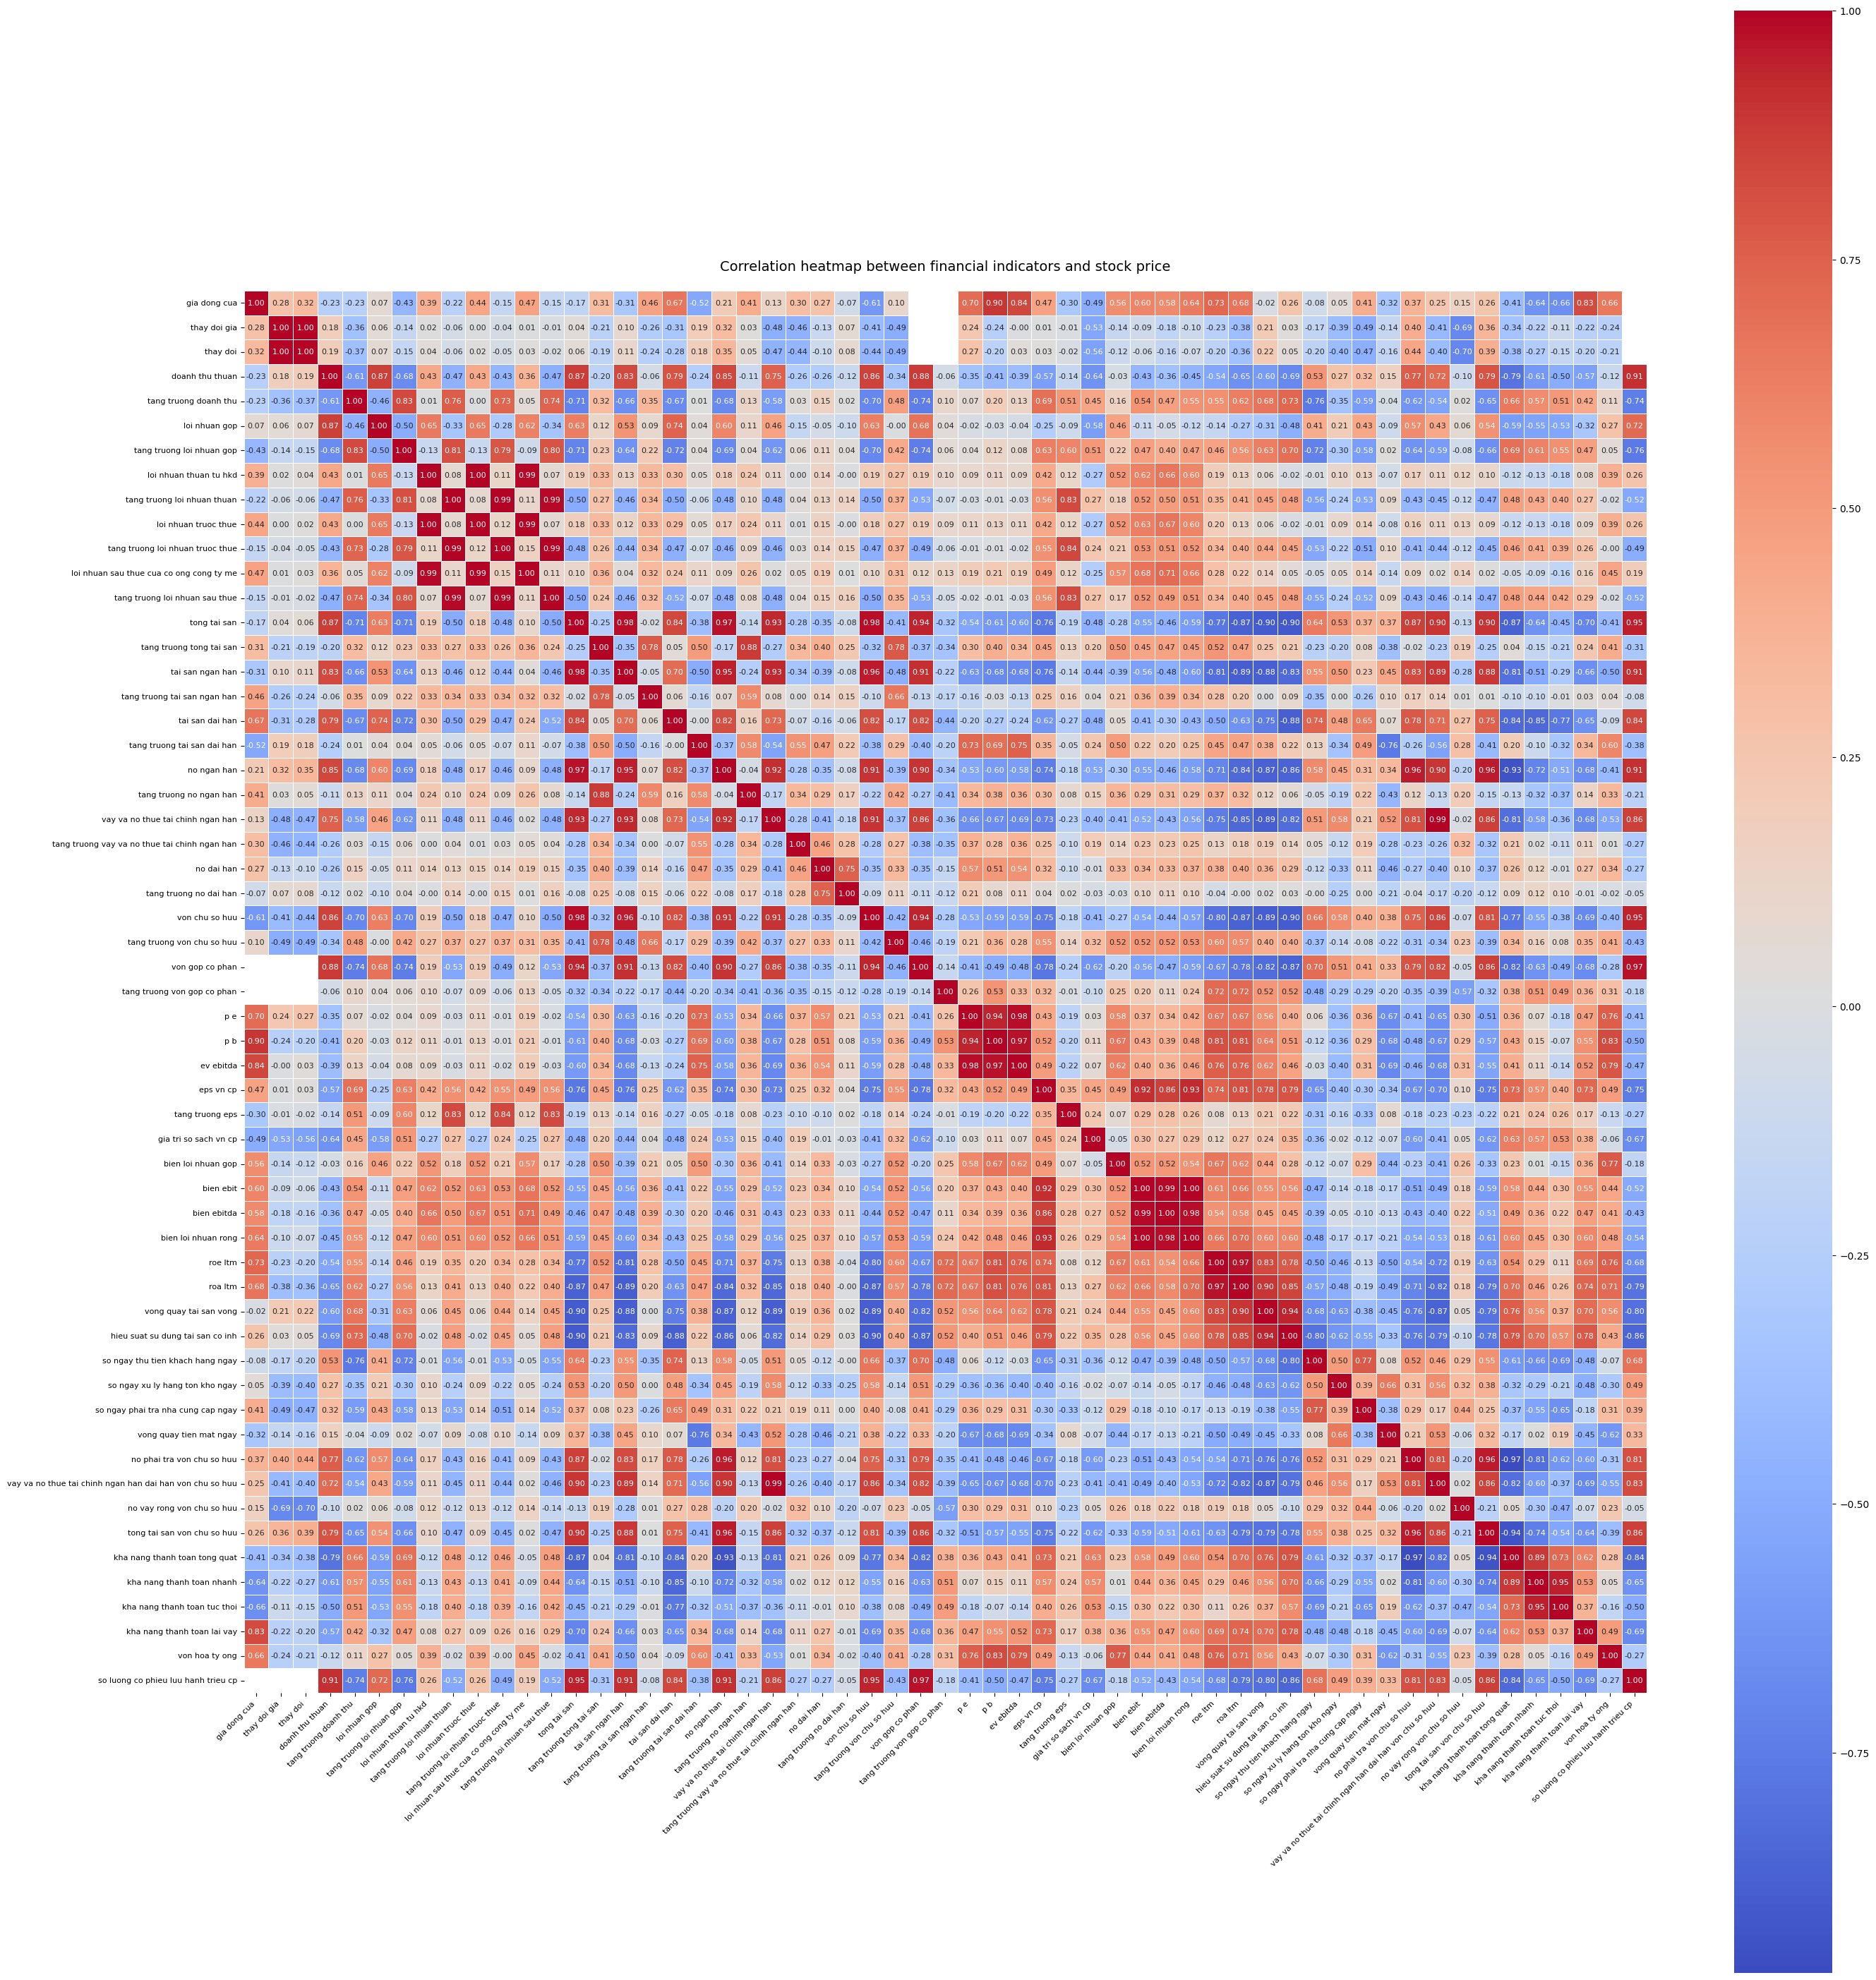

In [ ]:
corr = final_df.corr(numeric_only=True)

n_cols = corr.shape[1]
fig_width = max(12, n_cols * 0.5)
fig_height = fig_width

plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    annot_kws={"size": 8},
    linewidths=0.5,
    square=True
)

plt.title("Correlation heatmap between financial indicators and stock price", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

###### **3.2.2. Liệt kê 5 cột tương quan dương và 5 cột tương quan âm mạnh nhất**

In [ ]:
corr_price = corr['gia dong cua'].sort_values(ascending=False)
top_positive = corr_price[corr_price.index != 'gia dong cua'].head(5)
top_negative = corr_price[corr_price.index != 'gia dong cua'].tail(5)

print("\nTop 5 positive correlations with stock price:")
display(top_positive)

print("\nTop 5 negative correlations with stock price:")
display(top_negative)


Top 5 positive correlations with stock price:


,gia dong cua
p b,0.8981
ev ebitda,0.8450
kha nang thanh toan lai vay,0.8250
roe ltm,0.7269
p e,0.7019



Top 5 negative correlations with stock price:


,gia dong cua
kha nang thanh toan nhanh,-0.6393
kha nang thanh toan tuc thoi,-0.6577
von gop co phan,NaN
tang truong von gop co phan,NaN
so luong co phieu luu hanh trieu cp,NaN


**Tại sao lại có tận 3 cột NaN? Chẳng lẽ dữ liệu chúng ta chuẩn hoá có vấn đề, hoặc phương pháp của chúng ta sai?**

Check lại bằng đoạn code sau:

In [ ]:
cols_to_check = ['gia dong cua', 'von gop co phan',
                 'tang truong von gop co phan',
                 'so luong co phieu luu hanh trieu cp']

for c in cols_to_check[1:]:
    valid = final_df[['gia dong cua', c]].dropna()
    print(f"\n→ {c}: {len(valid)} overlapping non-null rows")
    print(final_df[[c]].isna().sum(), "NaNs total in column")


→ von gop co phan: 16 overlapping non-null rows
von gop co phan    0
dtype: int64 NaNs total in column

→ tang truong von gop co phan: 2 overlapping non-null rows
tang truong von gop co phan    22
dtype: int64 NaNs total in column

→ so luong co phieu luu hanh trieu cp: 16 overlapping non-null rows
so luong co phieu luu hanh trieu cp    0
dtype: int64 NaNs total in column


Ta suy luận ra một cách giải thích như sau:

Với cột `von gop co phan`  và cột `so luong co phieu luu hanh trieu cp`, chúng có các giá trị là hằng số, lần lượt là `20899554450000` và `2089955445`, có nghĩa là không có sự biến thiên (variation).

Chúng ta biết rằng hệ số tương quan không xác định nếu một trong hai biến có độ lệch chuẩn bằng 0 (dẫn đến lỗi chia cho 0).

$r_{XY} = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y} =
\frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}}$

Thêm vào đó, các công ty hiếm khi thay đổi vốn điều lệ hàng quý, vì vậy điều này phần nào có thể đoán trước được.

Còn với cột `tang truong von gop co phan`, chỉ với 2 hàng có giá trị (non-null) trùng lặp, pandas không thể tính toán được hệ số tương quan Pearson có ý nghĩa cho cột này.

##### **3.3 Giá cổ phiếu của công ty này có thể có mối quan hệ phụ thuộc vào những chỉ số tài chính nào?**

#### Các chỉ báo có tương quan dương mạnh
| Chỉ Báo | Tương Quan | Diễn Giải |
|:--|--:|:--|
| **P/B (Tỷ lệ Giá trên Giá trị Sổ sách)** | **+0.8981** | Tỷ lệ P/B cao cho thấy kỳ vọng thị trường lớn so với giá trị sổ sách. Khi giá cổ phiếu tăng, P/B tự nhiên tăng theo, phản ánh niềm tin của nhà đầu tư vào sự tăng trưởng và khả năng sinh lời của công ty. |
| **EV/EBITDA** | **+0.8450** | Đo lường định giá doanh nghiệp so với lợi nhuận hoạt động. Giá cổ phiếu cao hơn làm tăng giá trị doanh nghiệp, dẫn đến EV/EBITDA cao hơn, phản ánh khả năng sinh lời mạnh mẽ và sự lạc quan của nhà đầu tư. |
| **Tỷ lệ Chi Trả Lãi Vay (Interest Coverage Ratio)** | **+0.8250** | Các công ty có khả năng chi trả chi phí lãi vay mạnh mẽ được coi là ổn định về tài chính, điều này có xu hướng hỗ trợ giá cổ phiếu cao hơn. |
| **ROE (Tỷ suất sinh lời trên vốn chủ sở hữu)** | **+0.7269** | ROE cao cho thấy việc sử dụng vốn của cổ đông hiệu quả để tạo ra lợi nhuận, ảnh hưởng tích cực đến giá trị cổ phiếu. |
| **P/E (Tỷ lệ Giá trên Lợi nhuận)** | **+0.7019** | Tỷ lệ P/E tăng phản ánh kỳ vọng ngày càng tăng của nhà đầu tư về tăng trưởng lợi nhuận trong tương lai, thường liên quan đến định giá cổ phiếu cao hơn. |

**Tóm tắt:**
Giá cổ phiếu của công ty cho thấy **mối quan hệ tích cực mạnh mẽ** với **các chỉ báo về khả năng sinh lời và định giá** - đặc biệt là P/B, P/E, EV/EBITDA, ROE, và khả năng chi trả lãi vay.
Điều này cho thấy những cải thiện về khả năng sinh lời, tỷ suất sinh lời trên vốn và định giá của nhà đầu tư trực tiếp thúc đẩy sự gia tăng giá cổ phiếu của công ty.



#### Các chỉ báo có tương quan âm mạnh
| Chỉ Báo | Tương Quan | Diễn Giải |
|:--|--:|:--|
| **Tỷ lệ Thanh Toán Nhanh (Quick Ratio)** | **-0.6393** | Tỷ lệ thanh toán nhanh cao có thể ngụ ý thanh khoản dư thừa và tài sản lưu động chưa được sử dụng hết, điều này có thể ảnh hưởng tiêu cực đến định giá thị trường. |
| **Tỷ lệ Tiền mặt (Thanh khoản tức thời)** | **-0.6577** | Tỷ lệ tiền mặt rất cao cho thấy tiền mặt nhàn rỗi hoặc ban quản lý thận trọng, báo hiệu tiềm năng tăng trưởng ngắn hạn thấp hơn. |
| **Vốn chủ sở hữu (Shareholders' Equity)** | **-0.6113** | Vốn chủ sở hữu tăng do phát hành cổ phiếu mới có thể làm loãng giá trị cổ phiếu hiện tại, dẫn đến mối quan hệ tiêu cực với giá cổ phiếu. |
| **Giá trị Sổ sách trên mỗi Cổ phiếu (Book Value per Share)** | **-0.4938** | Thường di chuyển ngược chiều với giá thị trường khi giá cổ phiếu tăng nhanh hơn giá trị sổ sách. |
| **Tăng trưởng Tài sản Dài hạn** | **-0.5181** | Mở rộng tài sản nhanh chóng có thể tạm thời làm giảm lợi nhuận, gây áp lực giảm lên giá cổ phiếu. |

**Tóm tắt:**
Các chỉ báo về thanh khoản và cấu trúc vốn cho thấy **tương quan tiêu cực** với giá cổ phiếu.
Điều này ngụ ý rằng khi công ty tích lũy thanh khoản quá mức hoặc mở rộng vốn chủ sở hữu quá nhanh mà không có tăng trưởng lợi nhuận tương xứng, thị trường sẽ phản ứng tiêu cực.

#### Các chỉ báo có mối quan hệ yếu hoặc không rõ ràng

Các chỉ báo như Tăng trưởng Doanh thu, Tăng trưởng EPS và Vòng quay Tài sản có tương quan thấp (`|r| < 0.3`), cho thấy **không có mối quan hệ tuyến tính mạnh mẽ** với giá cổ phiếu trong giai đoạn quan sát.

##### **3.4 Kết luận**

* Giá cổ phiếu của công ty phụ thuộc **mạnh mẽ nhất vào các chỉ số sinh lời và định giá** - đáng chú ý là **P/B, EV/EBITDA, Tỷ lệ Chi Trả Lãi Vay, ROE và P/E**.

* Những điều này phản ánh **niềm tin của nhà đầu tư, hiệu quả hoạt động và tỷ suất sinh lời trên vốn chủ sở hữu**, tất cả đều là những động lực chính thúc đẩy giá cổ phiếu tăng.

* Ngược lại, **các chỉ báo về thanh khoản và mở rộng vốn** (ví dụ: Tỷ lệ Thanh toán nhanh, Tỷ lệ Tiền mặt, Vốn chủ sở hữu) cho thấy **mối quan hệ tiêu cực**, cho thấy thanh khoản dư thừa hoặc vốn hóa quá mức mà không có tăng trưởng thu nhập tương ứng có thể dẫn đến định giá thị trường thấp hơn.